# Model Testing

In [7]:
# import libraries
import pickle

from pprint import pprint

from time import time

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_palette("hls")
sns.set_context("notebook")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.feature_selection import chi2
from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, HalvingRandomSearchCV, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping, Checkpoint

## Data Import
___

In [37]:
# Dataframe
path_df = "Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
####### SVM DATA ###################### 

# features_train 
path_features_train = "Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)
    

####### MLP DATA ######################    
# x_train 
path_x_train = "Pickles/x_train.pickle"
with open(path_x_train, 'rb') as data:
    x_train = pickle.load(data)

# y_train
path_y_train = "Pickles/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

# x_test
path_x_test = "Pickles/x_test.pickle"
with open(path_x_test, 'rb') as data:
    x_test = pickle.load(data)

# labels_test
path_y_test = "Pickles/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)    

## SVM Fit & Performance
___

In [29]:
# Import the final SVM model
final_svc = pickle.load(open('Models/final_svc.pickle', 'rb'))

#### Training Accuracy

In [30]:
final_svc_pred = final_svc.predict(features_test)

In [31]:
svm_train_ac = accuracy_score(labels_train, final_svc.predict(features_train))
print("The training accuracy is: ", svm_train_ac)

The training accuracy is:  0.9284375


#### Testing Accuracy

In [19]:
svm_test_ac =  accuracy_score(labels_test, final_svc_pred)
print("The test accuracy is: ", svm_test_ac)

The test accuracy is:  0.882


#### Cross Validated Accuracy

In [20]:
print('The cross validated accuracy is: ', cross_val_score(final_svc, features_train, labels_train, cv=3))

The cross validated accuracy is:  [0.88226472 0.88430527 0.88149259]


#### Classification Report

In [21]:
emotion_dict = {'sadness':0, 'joy':1, 'fear':2, 'anger':3, 'love':4, 'surprise':5}

print("Classification report")
print(classification_report(labels_test,final_svc_pred, target_names=emotion_dict))

Classification report
              precision    recall  f1-score   support

     sadness       0.90      0.94      0.92      1159
         joy       0.88      0.92      0.90      1352
        fear       0.85      0.86      0.85       475
       anger       0.91      0.85      0.88       542
        love       0.83      0.70      0.76       328
    surprise       0.81      0.67      0.73       144

    accuracy                           0.88      4000
   macro avg       0.86      0.82      0.84      4000
weighted avg       0.88      0.88      0.88      4000



#### Confusion Matrix

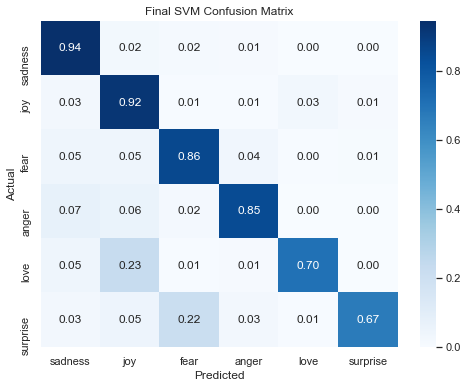

In [22]:
# create confusion matrix
cm_svc_final = confusion_matrix(labels_test, final_svc_pred)

# Normalise
cmn_svc_final = cm_svc_final.astype('float') / cm_svc_final.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_svc_final, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues')
plt.title('Final SVM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## MLP Fit & Performance
___
define the MLP network, then import trained model

In [10]:
# Network parameters
hidden_size = 100              
input_size = 2000
num_classes = 6                
dropout = 0.5
activation = F.relu

# Hyperparameters
batch_size = 256
lr = 0.001
epochs = 62
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss

# Define MLP Model 
class MLP(nn.Module):
     def __init__(
         self, 
         input_size = input_size, 
         hidden_size = hidden_size, 
         output_size = num_classes, 
         dropout = dropout,
         activation = activation
     ):
            
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)
 
     def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)

        return x

In [27]:
# Import the final MLP
final_MLP = pickle.load(open('Models/final_mlp.pickle', 'rb'))

#### Training Accuracy

In [33]:
# Training accuracy
mlp_train_ac = accuracy_score(y_train, final_MLP.predict(x_train))

print("The training accuracy is: ", mlp_train_ac)

The training accuracy is:  0.956625


#### Test Accuracy

In [40]:
# Test accuracy
mlp_pred = final_MLP.predict(x_test)
mlp_test_ac = accuracy_score(y_test, mlp_pred)
print("The test accuracy is: ", mlp_test_ac)

The test accuracy is:  0.866


#### Cross Validated Accuracy

In [39]:
# cross validated accuracy
print('The cross validated accuracy is: ', cross_val_score(final_MLP, x_train, y_train, cv=3));

  epoch    accuracy    balanced_accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  -------------------  ------------  -----------  ------------  ------
      1      0.3383               0.1667        1.7776       0.3383        1.7460  0.5292
      2      0.3383               0.1667        1.6893       0.3383        1.6473  0.5782
      3      0.5558               0.2921        1.6101       0.5558        1.5477  0.5541
      4      0.6036               0.3202        1.4864       0.6036        1.4318  0.5814
      5      0.6471               0.3727        1.4048       0.6471        1.3858  0.8783
      6      0.6973               0.4337        1.3573       0.6973        1.3474  0.6038
      7      0.7085               0.4497        1.3223       0.7085        1.3299  0.6748
      8      0.7099               0.4529        1.3066       0.7099        1.3211  0.6218
      9      0.7549               0.5178        1.2888       0.7549        1.3016  0.5842
     10   

#### Classification Report

In [41]:
print("Classification report")
print(classification_report(y_test, mlp_pred, target_names=emotion_dict))

Classification report
              precision    recall  f1-score   support

     sadness       0.88      0.93      0.90      1159
         joy       0.88      0.91      0.90      1352
        fear       0.83      0.84      0.84       475
       anger       0.88      0.84      0.86       542
        love       0.78      0.68      0.73       328
    surprise       0.82      0.58      0.68       144

    accuracy                           0.87      4000
   macro avg       0.84      0.80      0.82      4000
weighted avg       0.86      0.87      0.86      4000



#### Confusion Matrix

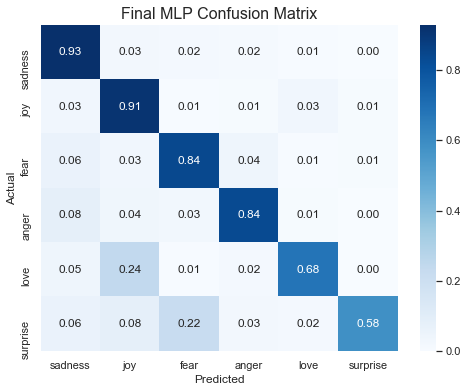

In [43]:
# create confusion matrix
cm_MLP = confusion_matrix(y_test, mlp_pred)

# Normalise
cmn_MLP= cm_MLP.astype('float') / cm_MLP.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_MLP, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues')
plt.title('Final MLP Confusion Matrix', fontsize= 16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()